By Taiheng.Zhang, Xiao.Yu

ID: 1715821；1715692 

# Description

The project starts with the simulation on the underlying stock price which applying Monte-Carlo method combining with Antithetic Variates method on discrete stochastic process of stock path via Euler schema. Then calculate the European option price with a certain strike price and maturity by averaging the discounted payoff from each simulated stock path and estimate the probability when the option is in the money or not at maturity with different strike prices. Also, the project will illustrate two hedging strategies including Delta neutral strategy and Delta-Gamma neutral strategy on a portfolio consisting of a Treasury bond, a call option in short position and its underlying stock and do some sensitivity tests. Finally, the project will analyze and compare the performance of different hedging strategies and aim to find an optimal hedging stratgy and give the corresponding weights to each asset in that portfolio.

# Process of optimal hedging strategies & Performance Analysis

Let Xs denotes the underlying stock price process, here modeled as a Ito’s lognormal process:
                   $$d \log X=\left(\mu(t, X(t))-\frac{1}{2} \sigma^{2}(t)\right) d t+\sigma(t) d W(t)$$               

where W(t) is a Weiner process:$$W\left(\mathrm{t}_{\mathrm{i}+1}\right)=W\left(t_{i}\right)+\sqrt{\mathrm{t}_{\mathrm{i}+1}-t_{i}} Z_{i+1} , i=0,1, \ldots, n-1, Z_{i+1} \sim N(0,1)$$  



Then we use Euler schema to discrete the process and get: $$\log \tilde{X}\left(t_{i+1}\right)=\log \tilde{X}\left(t_{i}\right)+\left(\mu\left(t_{i}, \tilde{X}\left(t_{i}\right)\right)-\frac{1}{2} \sigma^{2}\left(t_{i}\right)\right) \Delta t_{i}+\sigma\left(t_{i}\right) \Delta W\left(t_{i}\right)$$

And transform it into: $$X\left(t_{i+1}\right)=X\left(t_{i}\right)+\mu\left(t_{i},X\left(t_{i}\right)\right)\left(t_{i+1}-t_{i}\right)+\sigma\left(t_{i}, X\left(t_{i}\right)\right) \sqrt{t_{i+1}-t_{i}} Z_{i+1}$$ 
                                             
which be denoted as： $$S_{t_{i+1}}=S_{t_{i}} e^{\left(r-\frac{1}{2} \sigma^{2}\right)\left(t_{i+1}-t_{i}\right)+\sigma \sqrt{t_{i+1}-t_{i}} Z_{i+1}}$$

Hence, we can just get the stock prices by generating random variable Zi. Besides, we consider variance reduction and introduce Antithetic variates method. In this method, we generate a pair of simulated stock price Xi and Yi by Zi and get a final simulated stock price of each path by 


$$S_{i}=\frac{X_{i}+Y_{i}}{2}, i=1, \ldots, n$$

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [52]:
def EulerMilsteinMCStock_Control(scheme, parameters):
    
    np.random.seed(1000)

    T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # initialize values of model parameters
    S_0 = parameters['model']['S0']  # initial value
    sigma = parameters['model']['sigma']  # initial value
    rf = parameters['model']['rf']  # initial value    

    S1 = np.zeros((numSteps + 1, numPaths),dtype=float)
    S1[0,:] = np.log(S_0)
    
    S2 = np.zeros((numSteps + 1, numPaths),dtype=float)
    S2[0,:] = np.log(S_0)
  
    # Simulated the stock price by choosing different discretization scheme
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            Zs = np.random.normal(0, 1, 1)
            Zs_minus = -Zs 
            
            if scheme == 'Euler':
                S1[t_step,i] = S1[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs 
                S2[t_step,i] = S2[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs_minus 
            elif scheme == 'Milstein':    
                # Euler and Milstein have the same discretization scheme for Log(S) due to dsigma(t,X)/dX =0
                S1[t_step,i] = S1[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs  
                S2[t_step,i] = S2[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs_minus 
    # Variance reduction         
    return (np.exp(S1)+ np.exp(S2))/2

In this section, we calculate the call option price with a certain strike price and maturity by averaging the discounted payoff from each simulated path:

$$C_{0}\left(K, t_{k}\right)=e^{-r t_{k}}\left\{\frac{1}{n_{\text {path}}} \sum_{j=1}^{n_{\text {path}}}\left[S\left(t_{k}, \omega_{j}\right)-K\right]^{+}\right\}$$

In [53]:
def MC_option_price(S_T, parameters):

    S0 = parameters['model']['S0']
    sigma = parameters['model']['sigma']
    K = parameters['asset']['K'] 
    rf = parameters['model']['rf']
    T = parameters['setup']['T']    
    option_type = parameters['asset']['optype'] 
    
    DF = np.exp(-rf*T)  
    
    numPaths = parameters['setup']['numPaths']
    
    payoffs = np.maximum(0, (S_T- K) if option_type == 1 else (K-S_T))
    
    MC_optionprice = DF*(np.sum(payoffs)/numPaths)
    
    return MC_optionprice

In [54]:
if __name__=="__main__": # main setup of the market
    
    S0 = 100
    sigma = 0.40
    K = 100
    rf = 0.025    
    T = 2        
    
    # discrete setup
    N = 100  
    dt = T/N
    M = 5000
    
    Optype = 1 # 1: call -1: put 
    parameters = {'model':{'S0':S0, 'sigma':sigma, 'rf':rf},                 
                  'asset':{'K':K, 'optype': Optype},
                  'setup':{'T':T, 'numSteps':N, 'dt': T/N, 'numPaths':M}                
                 }
    
    # simulate stock prices based on main setup
    Sim_S = EulerMilsteinMCStock_Control('Euler', parameters)
    # print(pd.DataFrame(Sim_S))  # check    

#### Question (a)

In [55]:
S_T = Sim_S[-1,:]
MC_price = MC_option_price(S_T, parameters)
print(MC_price)

9.20093662579696


#### Question (b)

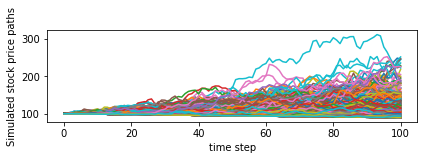

When M = 1000 , Stand error= 23.584719467251343


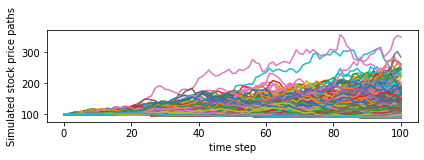

When M = 2000 , Stand error= 24.20233934406911


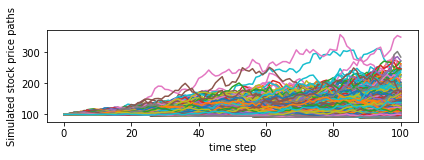

When M = 3000 , Stand error= 23.605519641522555


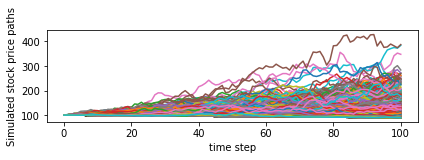

When M = 4000 , Stand error= 24.271947245452232


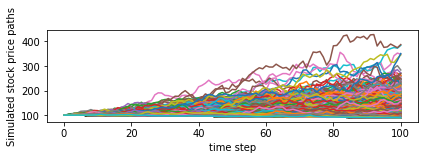

When M = 5000 , Stand error= 24.039367065786063


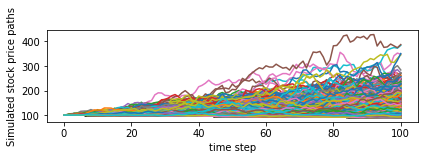

When M = 6000 , Stand error= 24.00651300138879


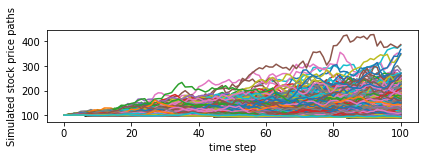

When M = 7000 , Stand error= 24.11866525272651


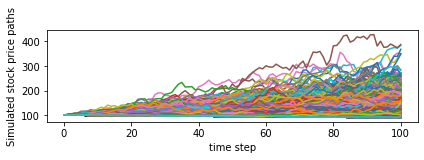

When M = 8000 , Stand error= 23.85450840611784


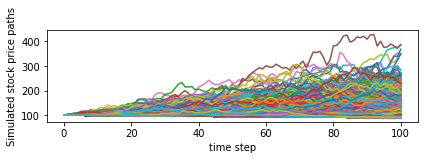

When M = 9000 , Stand error= 23.41876223157186


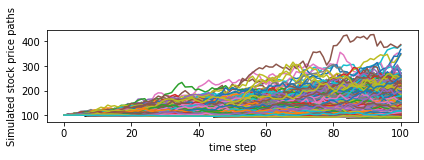

When M = 10000 , Stand error= 23.553126331653107
[9.33516844 9.35958633 9.24384172 9.30955268 9.20093663 9.29410088
 9.22822875 9.09128633 8.90040338 9.00379164]


In [56]:
M_=np.arange(1000,11000,1000,dtype=int)
len_M=len(M_)
MC_price_diffM=np.zeros(len_M)
for i in range(len_M):
    parameters['setup']['numPaths']=M_[i]
    Sim_S = EulerMilsteinMCStock_Control('Euler', parameters)
    S_T=Sim_S[-1,:]
    MC_price_diffM[i]= MC_option_price(S_T, parameters)
    plt.figure(figsize=(6,2))
    plt.plot(Sim_S)
    plt.ylabel('Simulated stock price paths')
    plt.xlabel('time step')    
    plt.tight_layout()
    plt.show()
    print('When M =' , M_[i] , ', Stand error=' , np.std(S_T))
print(MC_price_diffM)

###### After changing M from 1000 to 10000 with a step length 1000, it seems that all the stand errors of stock prices stay at a same level（23.2-24.3）. So, there is no apparent relationship between number of simulative path and accuracy of the simulation.

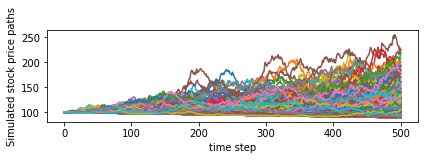

When N = 500 , Stand error= 22.84838764279279


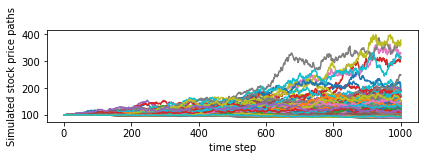

When N = 1000 , Stand error= 32.04768396727982


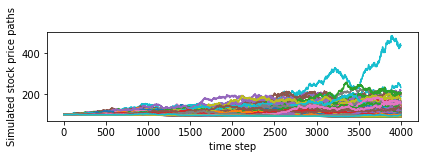

When N = 4000 , Stand error= 27.001027800607634


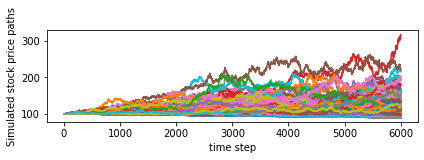

When N = 6000 , Stand error= 22.260039948027067


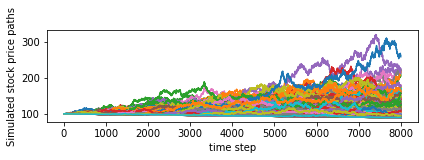

When N = 8000 , Stand error= 22.451767010690883


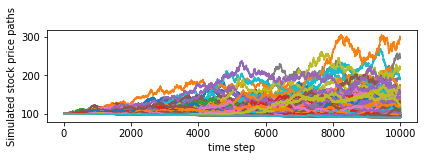

When N = 10000 , Stand error= 21.290008154455826
[ 8.94316693 11.04802874  9.66898736  8.261455    8.50383368  7.45523214]


In [57]:
N_=[500,1000,4000,6000,8000,10000]
len_N=len(N_)
MC_price_diffN=np.zeros(len_N)
for i in range(len_N):
    parameters['setup']['numPaths']=500
    parameters['setup']['numSteps']=N_[i]
    parameters['setup']['dt']=T/(N_[i])
    Sim_S = EulerMilsteinMCStock_Control('Euler', parameters)
    S_T=Sim_S[-1,:]
    MC_price_diffN[i]= MC_option_price(S_T, parameters)
    plt.figure(figsize=(6,2))
    plt.plot(Sim_S)
    plt.ylabel('Simulated stock price paths')
    plt.xlabel('time step')    
    plt.tight_layout()
    plt.show()
    print('When N =' , N_[i] , ', Stand error=' , np.std(S_T))
print(MC_price_diffN)

###### The stand error of stock prices keeps decreasing when N increases from 1000 to 10000, this indicates that more time step N will reduce the volatility of simulation. Therefore, if we want to make our simulation more accurate, we should increase the step number per unit time to make each simulative path more detailed.

#### Question (c)

By finite difference schemas, we can work out the partial derivative of option price with respect to its strike price:

$$\frac{\partial c_{0}}{\partial K}=e^{-r T}\left[\int_{S_{T}>K}(-1) f\left(S_{T}\right) d S_{T}\right]=\left(-e^{-r T}\right) \int_{S_{T}>K} f\left(S_{T}\right) d S_{T}=\left(-e^{-r T}\right) \operatorname{prob}\left(S_{T}>K\right)$$


Hence, we get the probability about the relation between option price and its different strike price:

$$\operatorname{prob}\left(S_{T}>\tilde{K}\right)=-e^{r T} \frac{\partial c_{0}}{\partial \tilde{K}} ; \operatorname{prob}\left(1_{S_{T}=\tilde{K}}\right)=e^{r T} \frac{\partial^{2} c_{0}}{\partial \tilde{K}^{2}}$$

In [6]:
def ProbHigherThanK(K_set, MC_price_Ks, parameters):
    
    rf = parameters['model']['rf']
    Factor = np.exp(rf*T)      
    num_K = len(K_set)
    cum_probs = np.zeros(num_K)
    
    for i in range(num_K-1):  
        
        dK = K_set[i] - K_set[i+1]         
        price_k_plus_1 = MC_price_Ks[i]
        price_k = MC_price_Ks[i+1]        
        cum_probs[i+1] = (price_k_plus_1 - price_k)/dK
    
    cum_probs = -cum_probs * Factor
    
    return cum_probs   

In [7]:
def Density_prob(K_set, MC_price_Ks, parameters):
    
    rf = parameters['model']['rf']
    Factor = np.exp(rf*T)     
    num_K = len(K_set)
    den_probs = np.zeros(num_K)
    
    for i in range(1,num_K-1):  
        
        dK = K_set[i] - K_set[i-1]               
        price_k_plus_1 = MC_price_Ks[i-1]
        price_k = MC_price_Ks[i]
        price_k_minus_1 = MC_price_Ks[i+1]       
        den_probs[i] = (price_k_plus_1 - 2*price_k + price_k_minus_1)/(dK**2)
    
    den_probs = den_probs * Factor
    
    return den_probs

In [8]:
K_set = np.arange(0,51,1,int)
num_K = len(K_set)
MC_price_Ks = np.zeros(num_K)
for i in range(num_K):
    parameters['asset']['K'] = K_set[i]        
    MC_price_Ks[i] = MC_option_price(S_T, parameters)
    
MC_K_vs_price = pd.DataFrame(np.transpose([K_set,MC_price_Ks]), index =list(range(0, num_K)), columns=['K', 'Price'])
# print(MC_K_vs_price)

In [9]:
# estimate culumative probs
HigherThanK_prob = ProbHigherThanK(K_set, MC_price_Ks, parameters)
    
# estimate density probs
den_probs = Density_prob(K_set, MC_price_Ks, parameters)

Text(0, 0.5, 'Prob(ST<K)')

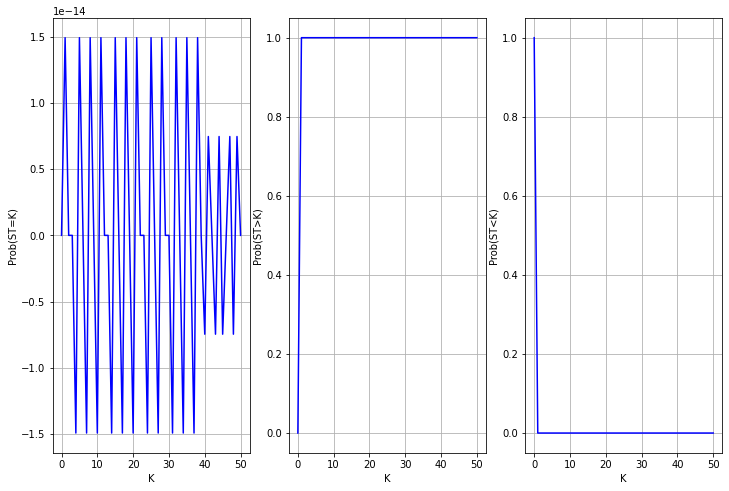

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.plot(K_set, den_probs, 'b')
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Prob(ST=K)')

plt.subplot(1,3,2)
plt.plot(K_set, HigherThanK_prob, 'b')
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Prob(ST>K)')
    
plt.subplot(1,3,3)
plt.plot(K_set, 1-HigherThanK_prob, 'b')
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Prob(ST<K)')

###### Analysis: The density figure indicates high probability that the option is always in the money when K is between 0 and 50, there is always a quite low probability that St equals to K.

Delta hedging is based on the notion of insulating portfolios from small movements in the underlying
asset price by taking an offsetting option position. Assume our portorfolio is:
        
$$\Pi(t)=-C(t)+n_{s} S(t)+n_{B} B(t)$$

Since the stock price simulation has been completed and the bond is defined following a process under risk-nuetral probability as: $$\frac{d B(t)}{B(t)}=r d t$$

which equal to $$B_{t+\Delta t}=B_{t} e^{r \Delta t}$$

Here we can ues Black-shole model to price this call option: $$C(t)=S(t) N\left(d_{1}\right)-e^{-r(T-t)} N\left(d_{2}\right)$$
                        
            
          
            
$$d_{1}=\frac{\ln (S(t) / K)+\left(r+\frac{\sigma^{2}}{2}\right)(T-t)}{\sigma \sqrt{T-t}} ; d_{2}=d_{1}-\sigma \sqrt{T-t}$$

Under B-S model, the delta can be worked out as:
          
$$\Delta=\frac{\partial C(t)}{\partial S(t)}=\frac{\partial}{\partial S(t)}\left[S(t) N\left(d_{1}\right)\right]-e^{-r(T-t)} K \frac{\partial}{\partial S(t)}\left[N\left(d_{2}\right)\right]=N\left(d_{2}\right)$$

For static delta-nuetral hedging, our portfolio is self-financing. The main point is working out the initial weights for the hedging portfolio of stocks and bonds:
       
$$n_{S}=\left(-n_{c}\right) \frac{\partial C(0)}{\partial S(0)} ; n_{B}=\left(-n_{c}\right) C(0)-n_{S} S(0)$$
That's equal to 
     
$$n_{S}=\Delta ; n_{B}=-C(0)-n_{S} S(0)$$

#### Question (d)

In [23]:
def Black_ScholesPrice(parameters):

    S0 = parameters['model']['S0']
    sigma = parameters['model']['sigma']    
    rf = parameters['model']['rf']      
    K = parameters['option']['K']    
    T = parameters['option']['T']
    option_type = parameters['option']['optype']     
    DF = np.exp(-rf*T)
    
    d1 = (np.log(S0/K)+(rf+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 1:  # call
        option_price = S0 * norm.cdf(d1) - K * DF * norm.cdf(d2)
    elif option_type == -1: # put
        option_price = K * DF * norm.cdf(-d2) - S0 * norm.cdf(-d1) 
    
    return option_price

In [24]:
def Black_ScholesPrice_Paras(St, sigma, T, rf, option_type):

    DF = np.exp(-rf*T)    
    
    d1 = (np.log(St/K)+(rf+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 1:  # call
        option_price = St * norm.cdf(d1) - K * DF * norm.cdf(d2)
    elif option_type == -1: # put
        option_price = K * DF * norm.cdf(-d2) - St * norm.cdf(-d1) 
    
    return option_price

In [25]:
def Black_Scholes_Delta(parameters):

    # delta = N(d1) under Black-Scholes option pricing model    
    S0 = parameters['model']['S0']
    sigma = parameters['model']['sigma']    
    rf = parameters['model']['rf']    
    K = parameters['option']['K'] 
    T = parameters['option']['T']  
    option_type = parameters['option']['optype'] 
    
    d1 = (np.log(S0/K)+(rf+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    
    if option_type == 1:  # call    
        bs_delta = norm.cdf(d1)
    else:    
        bs_delta = norm.cdf(d1) - 1    
    
    return bs_delta 

In [26]:
def Black_Scholes_Gamma(parameters):
    
    # gamma = phi(d1)/S_t/(sigma*sqrt(T)) under B-S pricing model    
    S0 = parameters['model']['S0']
    sigma = parameters['model']['sigma']    
    rf = parameters['model']['rf']
    K = parameters['option']['K'] 
    T = parameters['option']['T']    
    
    d1 = (np.log(S0/K)+(rf+0.5*sigma**2)*T)/(sigma*np.sqrt(T))    
    bs_gamma = norm.pdf(d1)/S0/(sigma*np.sqrt(T))
    
    return bs_gamma 

In [27]:
def DeltaGammaNeutralHedging(Sim_S,parameters):

    # strategy
    n_c = parameters['strategy']['n_c'] 
    n_s = parameters['strategy']['n_s'] 
    n_b = parameters['strategy']['n_b'] 
    k = parameters['strategy']['k'] # k= 0:delta-neutral,otherwise delta-gamma-neutral
    
    # time discretion setup
    T = parameters['setup']['T']  
    numSteps = parameters['setup']['numSteps']  
    numPaths = parameters['setup']['numPaths']  
    dt = parameters['setup']['dt']
    
    # model
    sigma = parameters['model']['sigma'] 
    rf = parameters['model']['rf']   
    
    # Option_A
    K = parameters['asset']['K'] 
    option_type_1 = parameters['asset']['optype'] 
    
    # Option_B
    K_2 = parameters['option']['K']  
    T_2 = parameters['option']['T']   
    option_type_2 = parameters['option']['optype'] 
    
    # Initialize replication errors
    PI = np.zeros((numSteps + 1, numPaths),dtype=float)
    PI[0,:] = 0 
    
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            S_t_i = Sim_S[t_step,i]
            T_new = T - dt * t_step  
            T_2_new = T_2 - dt * t_step 
            
            if T_new > 0:     # before T
                price_1_t_i = Black_ScholesPrice_Paras(S_t_i, sigma, T_new, rf, option_type_1)               
            elif T_new == 0:   # at T
                price_1_t_i = np.maximum(0, (S_t_i- K) if option_type_1 == 1 else (K-S_t_i)) 
            
            if k != 0:  # delta-gamma-neutral hedging
                price_2_t_i = Black_ScholesPrice_Paras(S_t_i, sigma, T_2_new, rf, option_type_2)  
            else:       # delta-gamma hedging
                price_2_t_i = 0            
            # work out replication errors under static trading strategy
            PI[t_step,i] = n_c*price_1_t_i + n_s*S_t_i + k*price_2_t_i + n_b*(1+rf*dt)  
            
    return PI        

In [28]:
# work out the heding ratio of the assets in portfolio under delta nuetral strategy
parameters = {'model':{'S0':S0, 'sigma':sigma, 'rf':rf},                 
             'asset':{'K':K, 'optype':Optype},
                'option':{'K':0, 'optype':0, 'T':0},   
                'setup':{'T':T, 'numSteps':N, 'dt': T/N, 'numPaths':M},                
                'strategy':{'n_c':0, 'n_s':0, 'n_b':0, 'k':0}   
                 }
parameters_1 = parameters  
parameters_1['option']['K'] = K
parameters_1['option']['optype'] = Optype  # call
parameters_1['option']['T'] = T  
    
BS_price_1 = Black_ScholesPrice(parameters_1)    
delta_1 = Black_Scholes_Delta(parameters_1)
gamma_1 = Black_Scholes_Gamma(parameters_1)
    
parameters_1['strategy']['n_c'] = -1 # -1: a short position in Option_A
parameters_1['strategy']['n_s'] = delta_1
parameters_1['strategy']['n_b'] = -(parameters_1['strategy']['n_c']*BS_price_1 
                                        + parameters_1['strategy']['n_s']* parameters_1['model']['S0'])    
parameters_1['strategy']['k'] = 0   
print('parameter_1=\n')
print(parameters_1)

parameter_1=

{'model': {'S0': 100, 'sigma': 0.4, 'rf': 0.025}, 'asset': {'K': 100, 'optype': 1}, 'option': {'K': 100, 'optype': 1, 'T': 2}, 'setup': {'T': 2, 'numSteps': 100, 'dt': 0.02, 'numPaths': 5000}, 'strategy': {'n_c': -1, 'n_s': 0.6447672796293542, 'n_b': -40.22844954763912, 'k': 0}}


In [17]:
PI_DN=DeltaGammaNeutralHedging(Sim_S,parameters_1)

Text(0.5, 1.0, 'Delta-Neutral Hedging')

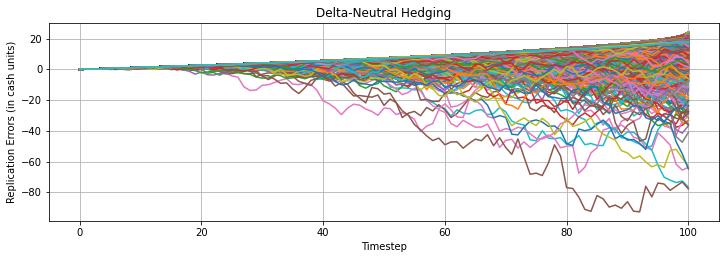

In [18]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(PI_DN)
plt.grid(True)
plt.xlabel('Timestep')
plt.ylabel('Replication Errors (in cash units)')
plt.title('Delta-Neutral Hedging')

###### Analysis: According to the figure, as time goes by, the replication errors of static delta hedging strategy will increase. It only have a good hedging performance in early stage

Text(0.5, 1.0, '(Static) Hedging Performance at Maturity(T)')

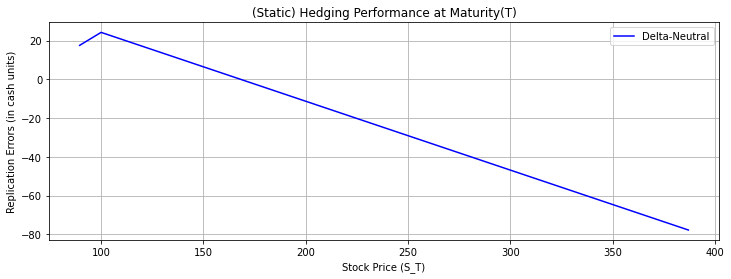

In [19]:
plt.figure(figsize=(12,4))
data_DN = np.transpose([Sim_S[-1,:],PI_DN[-1,:]])   
new_data_DN = data_DN[np.lexsort(data_DN[:,::-1].T)]  
plt.plot(new_data_DN[:,0],new_data_DN[:,1],"b",label='Delta-Neutral') 
plt.legend(loc=0) 
plt.grid(True)
plt.xlabel('Stock Price (S_T)')
plt.ylabel('Replication Errors (in cash units)')
plt.title('(Static) Hedging Performance at Maturity(T)')

###### Analysis：This figure show the relationship between stock price and replication errors (payoff of this portfolio). There is a short rise of replication errors when ST is less than 100. When the value of stcok probably reach 170, the error equals to zero, which means the hedging strategy hsa best performance at that point. In addition, when St becomes more than 170, the direction of replicaion errors will change and errors will keep incresing.  Our strategy was not able to offset changes in the underlying stock price.

Moreover, we would like to compare our simulation with the simulation without variance reduction here. (The replication error figure without variance reduction is attached below)

Text(0.5, 1.0, '(Static) Hedging Performance at Maturity(T)')

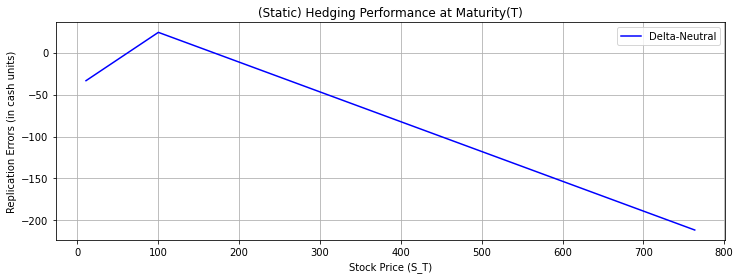

Obviously, no previous variance reduction will result in an comprehensive increasing (approaching 200%） in replication errors.

Go back to our main analysis

Text(0.5, 1.0, '(Static) Hedging Performance over tim [0,T]')

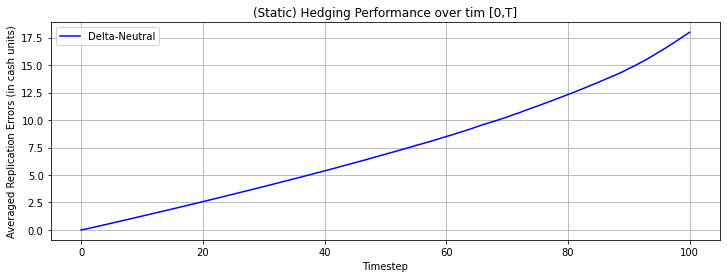

In [20]:
plt.figure(figsize=(12,4))
plt.plot(np.mean(PI_DN,axis=1),"b", label='Delta-Neutral')
plt.legend(loc=0) 
plt.grid(True)
plt.xlabel('Timestep')
plt.ylabel('Averaged Replication Errors (in cash units)')
plt.title('(Static) Hedging Performance over tim [0,T]')

###### Analysis：This figure more intuitively reflects the error keep increasing with time，the hedging performance is getting worse. 

Now we consider a dynamic delta-neutral hedging on our portfolio:
            
$$\begin{array}{l}
d \Pi(t)=n_{c}(t) d C(t)+n_{s}(t) d S(t)+r B(t) d t +\left[S(t) d n_{s}(t)+B(t) d n_{B}(t)\right]
\end{array}$$
which equal to:
          
$$r \Pi(t)+\left[n_{c}(t) C(t)\left(\mu_{c}-r\right)+n_{s}(t) S(t)(\mu-r)\right]+\left[\sigma_{c} n_{c}(t) C(t)+\sigma n_{s}(t) S(t)\right] d Z$$

To ensure no instantaneous risks exsiting，we ask 
       
$$\sigma_{c} n_{c}(t) C(t)+\sigma n_{s}(t) S(t)=0$$
         
so that $$\frac{n_{s}(t)}{n_{c}(t)}=-\frac{\sigma_{c} C(t)}{\sigma S(t)}=-\frac{\partial C}{\partial S}$$

Since we consider a call option in short position（nc= -1）, the weight of stock can be express as 
           
$$n_{S}\left(t_{k}\right)=\frac{\partial C\left(t_{k}\right)}{\partial S\left(t_{k}\right)}$$

Then we can work out the weight of our treasury bonds by
     
$$n_{B}\left(t_{k}\right)=n_{B}\left(t_{k-1}\right)-\frac{1}{B\left(t_{k}\right)}\left(n_{S}\left(t_{k}\right)-n_{S}\left(t_{k-1}\right)\right) S\left(t_{k}\right)$$

After implying the dynamic delta-neutral strategy by coding，we can give some figures which directly reflecting it performance

Text(0.5, 1.0, 'Delta-Neutral Hedging')

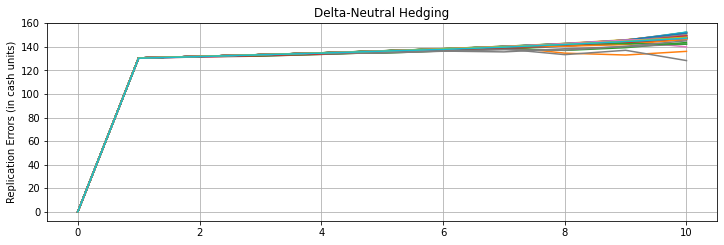

Text(0.5, 1.0, '(Static) Hedging Performance at Maturity(T)')

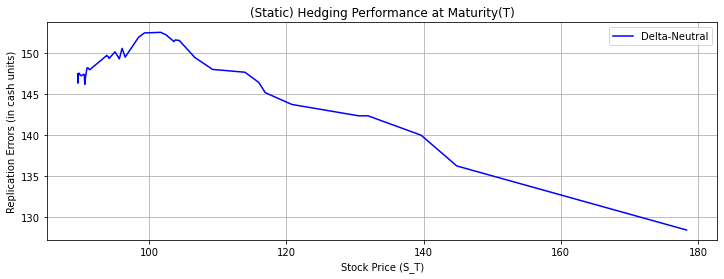

Text(0.5, 1.0, '(Static) Hedging Performance over tim [0,T]')

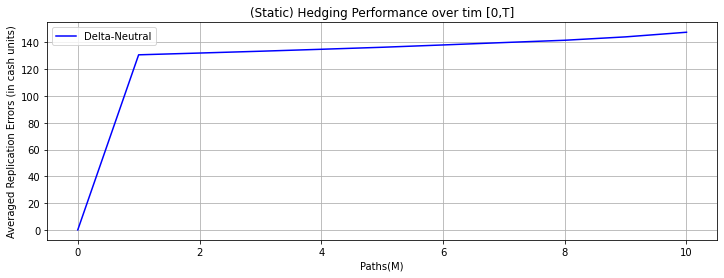

###### Analysis: These three figures show that the error quickly become stable and  float in a quite small range, which indicating that our hedging strategy would not change significantly over time. Also, we can find that It is less affected by changes in the underlying stock price. However, it still have a huge distance away from zero, which refecting that our dynamic strategy still have a insufficient performance for hedging.

The portfolio considered above is clearly not hedged against all types of risk. In addition to large movements in the stock price it is susceptible to changes in volatility and the risk free rate. If the underlying asset exhibits wide price swings, gamma need to be taken into consideration because gamma can correct hedging error by protecting against large movements in asset price.

Under B-s model, the gamma can be worked out as:$$k=-\frac{n_{c} \Gamma_{c}}{\Gamma_{c}}, n_{s}=\left(\Delta_{c}-k \Delta_{c 2}\right), n_{B}=C(0)-\Delta_{c} \mathrm{S}(0)-\mathrm{kC}_{2}(0)$$

For static delta-gamma nuetral hedging, we introduce a call optionB which on the same underlying stock with optionA, and firstly use gamma nuetral strategy to make:$$n_{c} \Gamma_{c}+k \Gamma_{c_{2}}=0$$
Then we can get the weight of optionB:$$ k=-n_{c} \Gamma_{c} / \Gamma_{c_{2}}$$

Also, we can working out the initial weights for stocks, bonds of the hedging portfolio:
           
$$n_{s}=\left(\Delta_{c}-k \Delta_{c 2}\right), n_{B}=C(0)-\Delta_{c} \mathrm{S}(0)-\mathrm{kC}_{2}(0)$$

#### Question (e)

Here, we first consider a call optionB with 3 years maturity.

In [46]:
#option_B  at t =0 
parameters_2 = parameters  
parameters_2['option']['K'] = K 
parameters_2['option']['optype'] = Optype  # call
parameters_2['option']['T'] = T + 1 
    
BS_price_2 = Black_ScholesPrice(parameters_2)    
delta_2 = Black_Scholes_Delta(parameters_2)
gamma_2 = Black_Scholes_Gamma(parameters_2)
    
parameters_2['strategy']['n_c'] = -1 # -1: a short position in Option_A
parameters_2['strategy']['k'] = -parameters_2['strategy']['n_c']*gamma_1/gamma_2
parameters_2['strategy']['n_s'] = -parameters_2['strategy']['n_c']*delta_1 - parameters_2['strategy']['k']* delta_2
parameters_2['strategy']['n_b'] = -(parameters_2['strategy']['n_c']*BS_price_1 
                                        + parameters_2['strategy']['n_s']* parameters_2['model']['S0']
                                        + parameters_2['strategy']['k']* BS_price_2)                                          
print('parameter_2=\n')
print(parameters_2)

print('option_1=%f vs option_2 = %f'%(BS_price_1, BS_price_2))
print('delta_1=%f vs delta_2=%f'%(delta_1, delta_2))
print('gamma_1=%f vs gamma_2=%f'%(gamma_1, gamma_2))

parameter_2=

{'model': {'S0': 100, 'sigma': 0.4, 'rf': 0.025}, 'asset': {'K': 100, 'optype': 1}, 'option': {'K': 100, 'optype': 1, 'T': 3}, 'setup': {'T': 2, 'numSteps': 100, 'dt': 0.02, 'numPaths': 5000}, 'strategy': {'n_c': -1, 'n_s': -0.21132541111370007, 'n_b': 7.506189476246703, 'k': 1.2676764768930897}}
option_1=24.248278 vs option_2 = 29.877205
delta_1=0.644767 vs delta_2=0.675324
gamma_1=0.006583 vs gamma_2=0.005193


In [47]:
PI_DGN = DeltaGammaNeutralHedging(Sim_S,parameters_2)  

Text(0.5, 1.0, 'Delta-Gamma-Neutral Hedging')

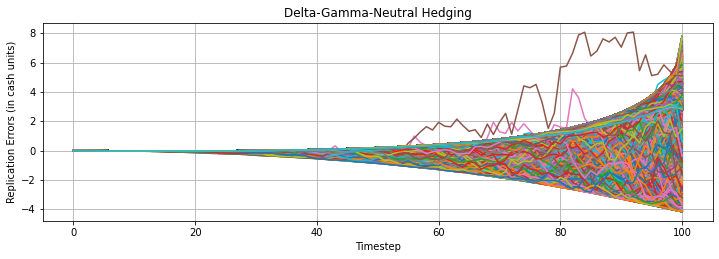

In [32]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,2)
plt.plot(PI_DGN)
plt.grid(True)
plt.xlabel('Timestep')
plt.ylabel('Replication Errors (in cash units)')
plt.title('Delta-Gamma-Neutral Hedging')

###### Analysis：Replication errors of Delta-Gamma-Neutral Hedging increase over time as well. But the error range becomes smaller.

Text(0.5, 1.0, '(Static) Hedging Performance at Maturity(T)')

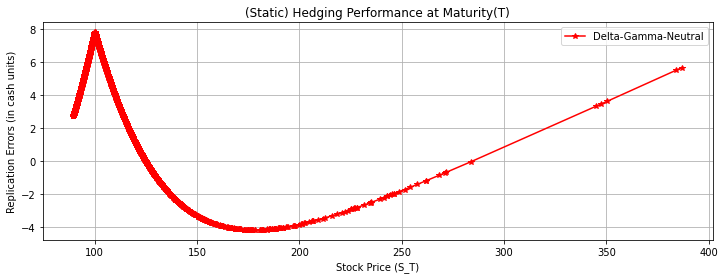

In [33]:
plt.figure(figsize=(12,4))
data_DGN = np.transpose([Sim_S[-1,:],PI_DGN[-1,:]])     
new_data_DGN = data_DGN[np.lexsort(data_DGN[:,::-1].T)] 
plt.plot(new_data_DGN[:,0],new_data_DGN[:,1],"r-*",label='Delta-Gamma-Neutral') 
plt.legend(loc=0) 
plt.grid(True)
plt.xlabel('Stock Price (S_T)')
plt.ylabel('Replication Errors (in cash units)')
plt.title('(Static) Hedging Performance at Maturity(T)')

###### Analysis：Replication errors fluctuate between -4 and 8. When stock price equals to approximately 125 and 275, the hedging performs best since its replication errors equal to 0.

In addition, we try to analyze the sensitivity between error of hedging stategy and maturity of OptionB by changing the maturity T from 3 years to 5 years and 8 years，and we get:

Text(0.5, 1.0, '(Static) Hedging Performance at Maturity(T)')

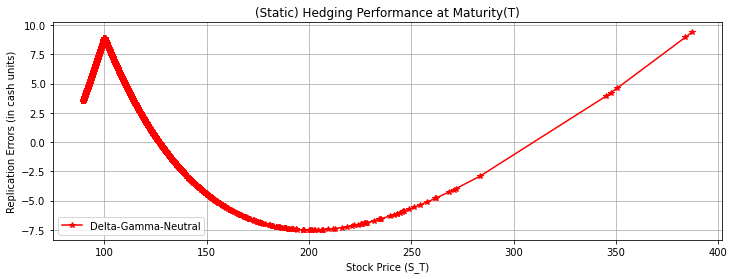

Text(0.5, 1.0, '(Static) Hedging Performance at Maturity(T)')

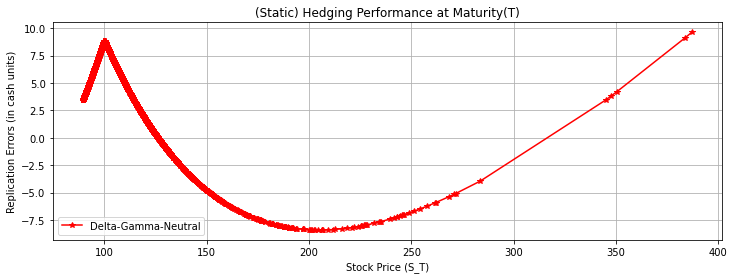

###### Analysis：We can find that the error has a slight sensitivity to the maturity of the additional option B. The error replication error will increases slightly if we choose a longer maturity call option as option B. Hence we could better choose a short maturity call option to our hedging strategy.

Beside, we try to analyze the sensibility between error and strike price of Option B, here we consider a optionB with 3 years maturity but have different K（K=120,140)

Text(0.5, 1.0, '(Static) Hedging Performance at Maturity(T)')

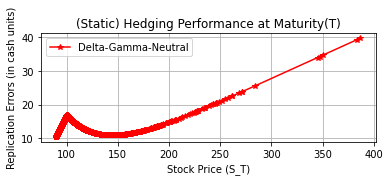

Text(0.5, 1.0, '(Static) Hedging Performance at Maturity(T)')

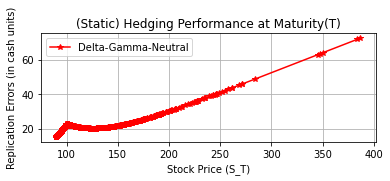

###### Analysis：This time we find that replication error has a large sensitivity to strike price of option B, the error will increse obviously if we choose a higher strike price call option as option B. Hence, we should consider a low strike price call option into our hedging strategy.

Then go back to our initial setup（T=3；K=100), we figure out the averaged error plot to have a futher look

Text(0.5, 1.0, '(Static) Hedging Performance over tim [0,T]')

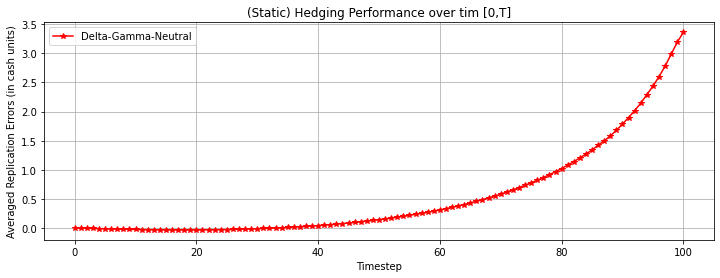

In [48]:
plt.figure(figsize=(12,4))
plt.plot(np.mean(PI_DGN,axis=1),'r-*',label='Delta-Gamma-Neutral')
plt.legend(loc=0) 
plt.grid(True)  
plt.xlabel('Timestep')
plt.ylabel('Averaged Replication Errors (in cash units)')
plt.title('(Static) Hedging Performance over tim [0,T]')

###### Analysis：This figure can shows similar conclusion, error is small and it will just slightly changes. Moreover, this figure shows that the static delta-gamma strategy can  performance best for a longer time. 

We also try the dynamic delta-gamma strategy on our portfolio, here are some figures which intuitively showing its performance

Text(0.5, 1.0, 'Delta-Gamma-Neutral Hedging')

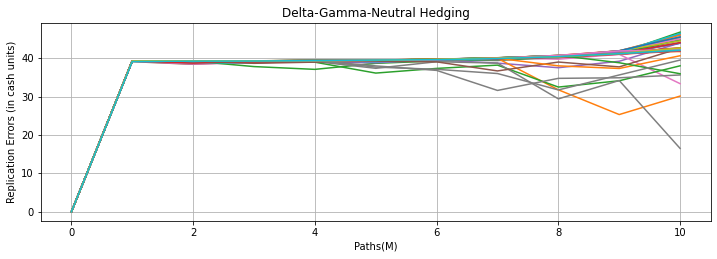

Text(0.5, 1.0, '(Static) Hedging Performance at Maturity(T)')

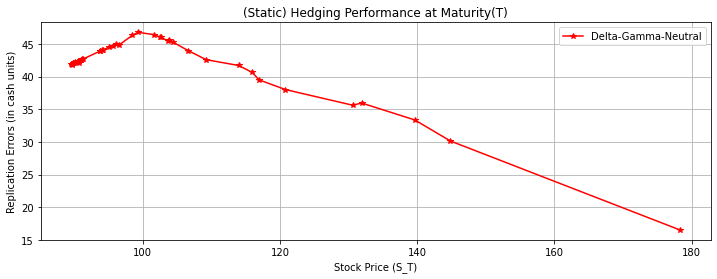

Text(0.5, 1.0, '(Static) Hedging Performance over tim [0,T]')

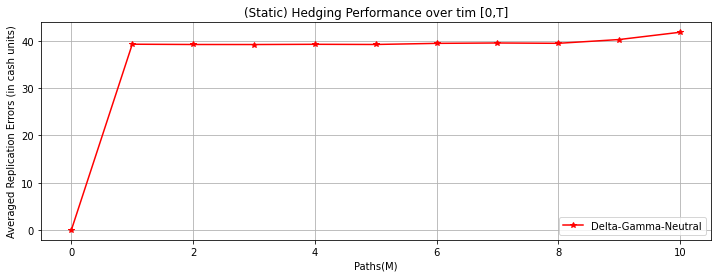

###### Analysis：There three figures that the error quickly become stable and  float in a quite small range, which indicating that our hedging strategy would not change significantly over time and almost not affected by stocks  Moreover, comparing with dynamic delta-neutral strategy, dynamic delta-gamma successfully curtail the error range of replication error.

# Comment On Result

Text(0.5, 1.0, '(Static) Hedging Performance over tim [0,T]')

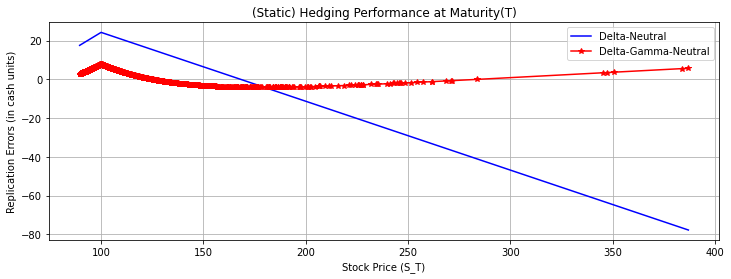

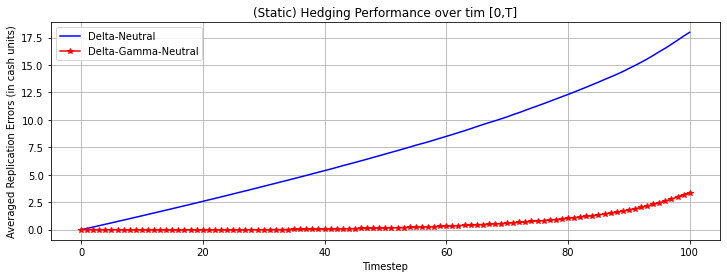

Text(0.5, 1.0, '(Static) Hedging Performance at Maturity(T)')

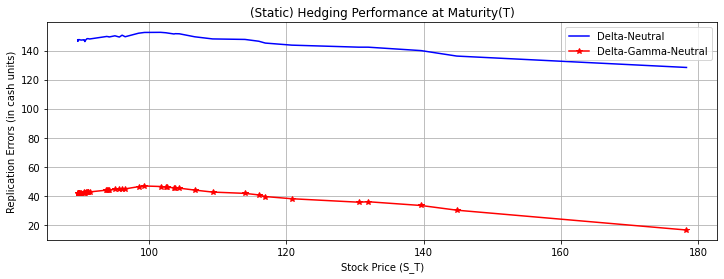

Text(0.5, 1.0, '(Static) Hedging Performance over tim [0,T]')

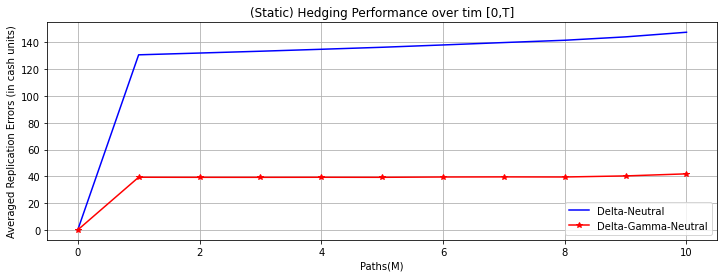

Actually, our example has showed that no matter choose dynamic or static, delta-gamma neutral hedging strategy is better than delta nuetral hedging strategy. This can be explained that the stock in our portfolio have a large volatility but delta neutral can only offset the impact from small fluctuation in stock prices. However, gamma makes our hedging strategy successfully offset the impact from large fluctuation in stock prices. By the way, the use of the delta-Gamma nuetral strategy may make us give up some possible potential benefits by bearing volatility risk, but it is certainly a better strategy for hedging. However, we believe the risk in option trading cannot be eliminated, and strict hedging do not exist, whatever be the hedging strategy. Hence, a good strategy with a rational investment mentality is the most important.